## Web Scraping

In [ ]:
!pip install selenium
!pip install undetected_chromedriver
!pip install webdriver-manager

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_md

In [5]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import manifold
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import undetected_chromedriver as uc
import time
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from itertools import combinations, product
import os
import warnings
import spacy
import operator
import io

# Ignore warnings
warnings.filterwarnings('ignore')


In [ ]:
options = uc.ChromeOptions()
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--window-size=1920,1080')
options.add_argument('--disable-blink-features=AutomationControlled')  # Helps avoid detection

# Initialize the Chrome WebDriver with the specified service
driver = uc.Chrome(options=options)


In [ ]:
# Initialize the WebDriver
driver = webdriver.Chrome()
# Open the webpage
webpage = 'https://www.ratebeer.com/top-beers'
driver.get(webpage)

# Use WebDriverWait to ensure the page is fully loaded
wait = WebDriverWait(driver, 20)

rate_beer = {}

# Loop to iterate over beer elements
for i in range(1, 51):  # Adjust the range as needed
    try:
        # Define beer name XPath (full XPath)
        beer_name_xpath = f'//*[@id="root"]/div[2]/div[2]/div/div/div/div/div/section[2]/div[2]/div/div/a[{i}]/div[2]/div[2]/div/div[1]'

        # Extract beer name using WebDriverWait to ensure the element is present
        beer_name_element = wait.until(EC.presence_of_element_located((By.XPATH, beer_name_xpath)))
        beer_name = beer_name_element.text

        # Define the full XPath for the <a> tag to extract the beer URL directly
        beer_url_xpath = f'//*[@id="root"]/div[2]/div[2]/div/div/div/div/div/section[2]/div[2]/div/div/a[{i}]'

        # Extract the URL from the <a> tag directly
        beer_url_element = wait.until(EC.presence_of_element_located((By.XPATH, beer_url_xpath)))
        beer_url = beer_url_element.get_attribute('href')

        # Add the beer name and URL to the dictionary
        rate_beer[beer_name] = beer_url

        # Optional: print for debugging
        print(f"Scraped: {beer_name} - {beer_url}")

    except Exception as e:
        print(f"Error occurred for beer {i}: {e}")

# Close the WebDriver after scraping
driver.quit()

# Output the beer names and URLs
print(rate_beer)

In [ ]:
# Initialize the WebDriver
driver = webdriver.Chrome()

# Dictionary to store ratings and comments
beer_data = {}

# Loop through each beer and its URL
for beer_name, beer_url in rate_beer.items():
    try:
        # Open the beer's URL
        driver.get(beer_url)
        time.sleep(2)

        # Toggle to 100 reviews per page by clicking on the dropdown (adjust the XPath if necessary)
        try:
            # Wait for the dropdown button to be clickable
            w1 = WebDriverWait(driver, 5)
            dd_element = w1.until(
                EC.element_to_be_clickable((By.XPATH, '//div[@role="button" and @aria-haspopup="listbox"]'))
            )
            dd_element.click()

            # Wait for the dropdown option list to become visible and click on "100"
            option_100 = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, '//li[contains(text(), "100")]'))
            )
            option_100.click()

            time.sleep(2)  # Wait for the page to load the 100 reviews
        except Exception as e:
            print(f"Error toggling to 100 reviews per page for {beer_name}: {e}")

        # Initialize a list to hold ratings and comments for this beer
        beer_data[beer_name] = []

        # Scrape top 100 comments
        for i in range(1, 101):  # Loop through the first 100 comments
            try:
                # XPath for rating
                rating_xpath = f'//*[@id="root"]/div[2]/div[2]/div/div/div/div[2]/div[1]/div[2]/div/div[3]/div[{i}]/div/section[1]/div[2]/div[2]/div[2]/span[1]'
                # XPath for the comment without 'Show More'
                review_comment_xpath_no_show = f'//*[@id="root"]/div[2]/div[2]/div/div/div/div[2]/div[1]/div[2]/div/div[3]/div[{i}]/div/section[2]/div[1]/div/div[1]/div'
                # XPath for the comment with 'Show More'
                comment_show_more_xpath = f'//*[@id="root"]/div[2]/div[2]/div/div/div/div[2]/div[1]/div[2]/div/div[3]/div[{i}]/div/section[2]/div[1]/div/div[1]'
                # XPath for 'Show More' button
                show_more_xpath = f'//*[@id="root"]/div[2]/div[2]/div/div/div/div[2]/div[1]/div[2]/div/div[3]/div[{i}]/div/section[2]/div[1]/div/button/span[1]'

                # Extract the rating
                rating_element = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.XPATH, rating_xpath))
                )
                rating_text = rating_element.text

                # Check if 'Show More' button exists and handle accordingly
                try:
                    show_more_button = driver.find_element(By.XPATH, show_more_xpath)
                    if show_more_button:
                        show_more_button.click()  # Click 'Show More' button to expand the comment
                        time.sleep(2)  # Give time for the comment to expand
                        comment_xpath = comment_show_more_xpath
                    else:
                        comment_xpath = review_comment_xpath_no_show

                except Exception as e:
                    # No 'Show More' button, proceed with the regular comment xpath
                    comment_xpath = review_comment_xpath_no_show
                    print(f"No 'Show more' button found for comment {i}: {e}")

                # Extract the comment
                comment_element = WebDriverWait(driver, 5).until(
                    EC.presence_of_element_located((By.XPATH, comment_xpath))
                )
                comment_text = comment_element.text

                # Append the data to the beer_data dictionary
                beer_data[beer_name].append({
                    'Comment Number': i,
                    'Rating': rating_text,
                    'Comment': comment_text
                })

                # Print for debugging
                print(f"Beer Name: {beer_name}, Rating: {rating_text}, Comment: {comment_text}")

            except Exception as e:
                print(f"Error extracting comment {i} for {beer_name}: {e}")

    except Exception as e:
        print(f"Error occurred while scraping {beer_name}: {e}")

# Close the WebDriver after scraping
driver.quit()

# Output the beer data dictionary
print(beer_data)


In [ ]:
import csv

# Specify the file name
csv_file = "beer_data.csv"

# Open the file in write mode
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    # Create a writer object
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(["Beer Name", "Comment Number", "Rating", "Comment"])

    # Loop through beer_data dictionary and write each review into the file
    for beer_name, reviews in beer_data.items():
        for review in reviews:
            writer.writerow([beer_name, review['Comment Number'], review['Rating'], review['Comment']])

print(f"Data successfully written to {csv_file}")


## Data Preprocessing

In [6]:
from google.colab import files

uploaded = files.upload()

dfs = []
for fn in uploaded.keys():
  dfs.append(pd.read_csv(io.BytesIO(uploaded[fn])))

beer_reviews = pd.concat(dfs, ignore_index=True)
print(len(beer_reviews))

Saving beer_data.csv to beer_data (1).csv
4103


In [7]:
beer_reviews.head()

,Beer_Name,Comment Number,Rating,Review
0,Toppling Goliath Kentucky Brunch,1,3.3,"You need personal informations from companies,..."
1,Toppling Goliath Kentucky Brunch,2,4.5,"Bottle after MBCC 2024. Black colour, malty ar..."
2,Toppling Goliath Kentucky Brunch,3,4.3,Thank you for sharing this Chris - Black with ...
3,Toppling Goliath Kentucky Brunch,4,4.7,"Boxed beer at home, proper glassware. Pitch bl..."
4,Toppling Goliath Kentucky Brunch,5,4.9,"From backlog. (As 2018 Vintage) 0,3 litre Bott..."


In [8]:
def preprocess_text(text):
    # Remove special characters and numbers
    reviews = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    # Remove extra spaces
    reviews = reviews.lower().strip()

    return reviews

beer_reviews['clean_review'] = beer_reviews['Review'].apply(preprocess_text)
beer_reviews.head()

,Beer_Name,Comment Number,Rating,Review,clean_review
0,Toppling Goliath Kentucky Brunch,1,3.3,"You need personal informations from companies,...",you need personal informations from companiesf...
1,Toppling Goliath Kentucky Brunch,2,4.5,"Bottle after MBCC 2024. Black colour, malty ar...",bottle after mbcc black colour malty aroma wi...
2,Toppling Goliath Kentucky Brunch,3,4.3,Thank you for sharing this Chris - Black with ...,thank you for sharing this chris black with a...
3,Toppling Goliath Kentucky Brunch,4,4.7,"Boxed beer at home, proper glassware. Pitch bl...",boxed beer at home proper glassware pitch blac...
4,Toppling Goliath Kentucky Brunch,5,4.9,"From backlog. (As 2018 Vintage) 0,3 litre Bott...",from backlog as vintage litre bottle from a ...


## Word Frequency

In [9]:
# Initialize CountVectorizer to count word frequencies, removing common English stopwords
vectorizer = CountVectorizer(stop_words='english')
vector = vectorizer.fit_transform(beer_reviews['clean_review'])

#Sum up the occurrences of each word
word_counts = vector.toarray().sum(axis=0)

# Get the vocabulary (the words themselves)
vocab = vectorizer.get_feature_names_out()

# Create a DataFrame for the word frequency
word_freq_df = pd.DataFrame({'word': vocab, 'count': word_counts})
# Sort the DataFrame by frequency
word_freq_df.sort_values(by='count', ascending=False, inplace = True)

In [10]:
#attributes selected as per dummies webiste
attributes = ['smooth','thick','mouthfeel','bitterness','dark','light','malt','froth','fruity','hoppy','malty','robust','clarity','aggressive','sweet', \
              'note','fruit','hop','carbonation','bitter' ]

In [11]:
#frequency distribution of these attributes in our reviews
top_15_attributes = word_freq_df[word_freq_df['word'].apply(lambda x: x in attributes)].sort_values(by='count',ascending=False)[:15]

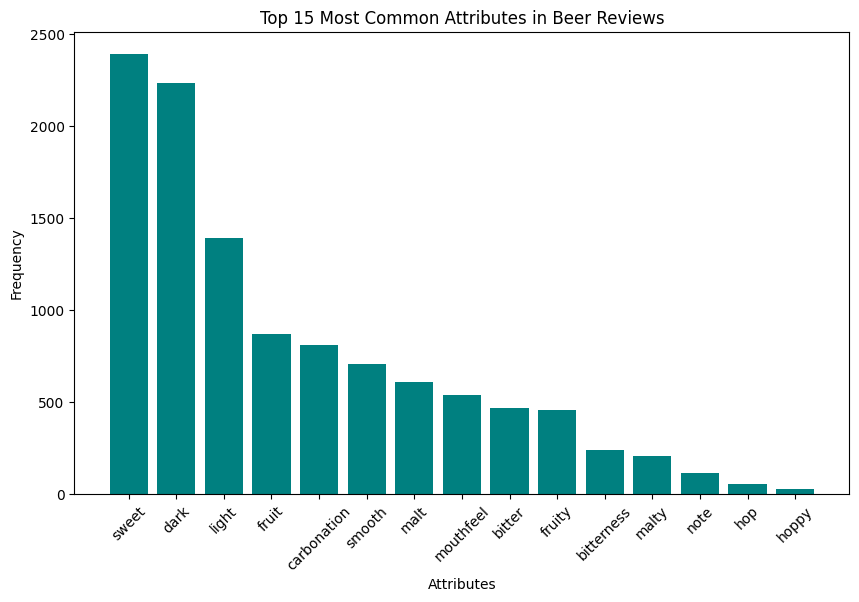

In [12]:
# Plot the top 15 most common words
plt.figure(figsize=(10,6))
plt.bar(top_15_attributes['word'], top_15_attributes['count'], color='teal')
plt.xticks(rotation=45)
plt.title('Top 15 Most Common Attributes in Beer Reviews')
plt.xlabel('Attributes')
plt.ylabel('Frequency')
plt.show()


**As per the above graph, the top 3 attributes in the data are :**


*   **Sweet**
*   **Dark**
*   **Light**


In [14]:
customer_attributes = ["sweet", "dark", "fruit"]
attributes_document = ' '.join(customer_attributes)

## Similarity Analysis : Bag of words

In [15]:
vectorizer = CountVectorizer(stop_words='english')

# Fit the vectorizer on the reviews to establish the vocabulary
vectorizer.fit(beer_reviews['clean_review'])

# Transform both reviews and attributes using the same vectorizer
vectorized_reviews = vectorizer.transform(beer_reviews['clean_review'])
vectorized_attributes = vectorizer.transform([attributes_document])

# Compute cosine similarity
similarity_scores = cosine_similarity(vectorized_attributes, vectorized_reviews).T

beer_reviews['similarity_bow'] = similarity_scores
beer_reviews.head()

,Beer_Name,Comment Number,Rating,Review,clean_review,similarity_bow
0,Toppling Goliath Kentucky Brunch,1,3.3,"You need personal informations from companies,...",you need personal informations from companiesf...,0.000000
1,Toppling Goliath Kentucky Brunch,2,4.5,"Bottle after MBCC 2024. Black colour, malty ar...",bottle after mbcc black colour malty aroma wi...,0.000000
2,Toppling Goliath Kentucky Brunch,3,4.3,Thank you for sharing this Chris - Black with ...,thank you for sharing this chris black with a...,0.211604
3,Toppling Goliath Kentucky Brunch,4,4.7,"Boxed beer at home, proper glassware. Pitch bl...",boxed beer at home proper glassware pitch blac...,0.000000
4,Toppling Goliath Kentucky Brunch,5,4.9,"From backlog. (As 2018 Vintage) 0,3 litre Bott...",from backlog as vintage litre bottle from a ...,0.000000


## Sentiment Analysis
#### Using Vader

In [16]:
# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to compute sentiment scores for a given review
def get_sentiment_scores(review):
    return sid.polarity_scores(review)

# Apply the sentiment analysis to all reviews
beer_reviews['sentiment_score'] = beer_reviews['clean_review'].apply(get_sentiment_scores)

# Expand the sentiment dictionary into separate columns (positive, negative, neutral, and compound scores)
sentiment_df = pd.json_normalize(beer_reviews['sentiment_score'])

# Merge sentiment scores back into the main DataFrame
beer_reviews['sentiment_score'] = sentiment_df['compound'] #pd.concat([beer_reviews, sentiment_df], axis=1)

beer_reviews[['Beer_Name', 'clean_review', 'similarity_bow', 'sentiment_score']].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,Beer_Name,clean_review,similarity_bow,sentiment_score
0,Toppling Goliath Kentucky Brunch,you need personal informations from companiesf...,0.000000,0.9442
1,Toppling Goliath Kentucky Brunch,bottle after mbcc black colour malty aroma wi...,0.000000,0.7778
2,Toppling Goliath Kentucky Brunch,thank you for sharing this chris black with a...,0.211604,0.9042
3,Toppling Goliath Kentucky Brunch,boxed beer at home proper glassware pitch blac...,0.000000,0.9423
4,Toppling Goliath Kentucky Brunch,from backlog as vintage litre bottle from a ...,0.000000,0.7845


## Similarity Analysis : SPACY

In [29]:
nlp = spacy.load("en_core_web_md")

attribute_docs = nlp(attributes_document)
reviews_docs = [nlp(review) for review in beer_reviews['clean_review']]

#Calculate similarity for each review and store it in a list
similarity_scores = [doc.similarity(attribute_docs) for doc in reviews_docs]
beer_reviews['similarity_spacy'] = similarity_scores

# Print the updated DataFrame with similarity scores
beer_reviews[['Beer_Name', 'Rating', 'similarity_spacy','similarity_bow', 'sentiment_score']].head()

,Beer_Name,Rating,similarity_spacy,similarity_bow,sentiment_score
0,Toppling Goliath Kentucky Brunch,3.3,0.315782,0.000000,0.9442
1,Toppling Goliath Kentucky Brunch,4.5,0.585625,0.000000,0.7778
2,Toppling Goliath Kentucky Brunch,4.3,0.659162,0.211604,0.9042
3,Toppling Goliath Kentucky Brunch,4.7,0.580113,0.000000,0.9423
4,Toppling Goliath Kentucky Brunch,4.9,0.484300,0.000000,0.7845


In [31]:
sorted_df = beer_reviews.sort_values(by='similarity_spacy', ascending=False,ignore_index=True)
sorted_df[['Beer_Name', 'Rating', 'similarity_bow', 'similarity_spacy','sentiment_score']].head()

,Beer_Name,Rating,similarity_bow,similarity_spacy,sentiment_score
0,Schramm's A Smile of Fortune,4.6,0.384900,0.880824,0.9785
1,Schramm's Madeline,4.0,0.492366,0.861999,0.8316
2,Three Floyds Dark Lord - Bourbon Barrel Aged,4.3,0.445435,0.860733,0.8176
3,Toppling Goliath SR-71 Blackbird (2015 Bottlin...,4.0,0.280976,0.857526,0.4588
4,Cigar City Hunahpu's Imperial Stout - Double B...,4.5,0.482451,0.856921,0.9444


### **Analysis:**

**BoW** represents text as a collection of word frequencies without considering the context. It merely counts the occurrences of exact words and ignores word order or meaning.

In contrast, **SpaCy** uses word embeddings that account for the context in which words appear, assigning similarity scores based on their meaning. This allows words with similar meanings to have high similarity, even if they are not identical.

When the dataframe containing beer reviews is sorted in descending order by the similarity score calculated with SpaCy, we can observe that SpaCy's scores increase significantly compared to BoW.





## Evaluation Score and Recommendation

1. **Averge Sentiments and Similarity Score:** We first calculated the average sentiment scores and similarity scores (using both Bag of Words and SpaCy embeddings) for each beer, grouped by Beer_Name.

2. **Evaludation Score:** We then merged these scores and computed an evaluation_score for each beer, which is calculated *the average of the sentiment and similarity scores.*

3. **Recommendation:** The beers are sorted based on their evaluation scores, and the top 3 beers are being recommended.

In [21]:
sentiment_avg = beer_reviews.groupby('Beer_Name')['sentiment_score'].mean().reset_index()
sentiment_avg = sentiment_avg.sort_values('sentiment_score', ascending=False)
sentiment_avg = sentiment_avg.reset_index(drop=True)

similarity_avg_bow = beer_reviews.groupby('Beer_Name')['similarity_bow'].mean().reset_index()
similarity_avg_bow= similarity_avg_bow.sort_values('similarity_bow', ascending=False)
similarity_avg_bow = similarity_avg_bow.reset_index(drop=True)

similarity_avg_spacy = beer_reviews.groupby('Beer_Name')['similarity_spacy'].mean().reset_index()
similarity_avg_spacy= similarity_avg_spacy.sort_values('similarity_spacy', ascending=False)
similarity_avg_spacy = similarity_avg_spacy.reset_index(drop=True)

review_bow = similarity_avg_bow.merge(sentiment_avg, on='Beer_Name')
review_bow['evaluation_score'] = review_bow[['similarity_bow','sentiment_score']].mean(axis=1)
review_bow.sort_values(by='evaluation_score', ascending=False,ignore_index=True, inplace=True)

review_spacy = similarity_avg_spacy.merge(sentiment_avg, on='Beer_Name')
review_spacy['evaluation_score'] = review_spacy[['similarity_spacy','sentiment_score']].mean(axis=1)
review_spacy.sort_values(by='evaluation_score', ascending=False,ignore_index=True, inplace=True)

print(f"\033[1mThe Top 3 recommendations based on \033[4mBag of Words\033[0m \033[1msimilarity scores are: \n1. {review_bow.Beer_Name[0]}\n2. {review_bow.Beer_Name[1]} \n3. {review_bow.Beer_Name[2]}\033[0m")
print("\n--------------------------------------------------------------------------------------------------------------------------\n")
print(f"\033[1mThe Top 3 recommendations based on \033[4mSPACY\033[0m \033[1msimilarity scores are: \n\n1. {review_spacy.Beer_Name[0]}\n2. {review_spacy.Beer_Name[1]} \n3. {review_spacy.Beer_Name[2]}\033[0m")

The Top 3 recommendations based on Bag of Words similarity scores are: 
1. Midnight Sun M
2. B. Nektar Ken Schramm Signature Series - The Heart of Darkness 
3. La Face Cachée de la Pomme Neige Récolte d'Hiver

--------------------------------------------------------------------------------------------------------------------------

The Top 3 recommendations based on SPACY similarity scores are: 

1. Midnight Sun M
2. La Face Cachée de la Pomme Neige Récolte d'Hiver 
3. Schramm's The Statement Reserve


In [32]:
print("The recommended beer with it's evaluation score is listed below for Bag of Words model:\n")
display(review_bow.iloc[:3])

The recommended beer with it's evaluation score is listed below for Bag of Words model:



,Beer_Name,similarity_bow,sentiment_score,evaluation_score
0,Midnight Sun M,0.192791,0.861487,0.527139
1,B. Nektar Ken Schramm Signature Series - The H...,0.158763,0.829873,0.494318
2,La Face Cachée de la Pomme Neige Récolte d'Hiver,0.144941,0.812770,0.478855


In [33]:
print("The recommended beer with it's evaluation score is listed below for Spacy model:\n")
display(review_spacy.iloc[:3])

The recommended beer with it's evaluation score is listed below for Spacy model:



,Beer_Name,similarity_spacy,sentiment_score,evaluation_score
0,Midnight Sun M,0.585393,0.861487,0.723440
1,La Face Cachée de la Pomme Neige Récolte d'Hiver,0.609710,0.812770,0.711240
2,Schramm's The Statement Reserve,0.647807,0.758060,0.702933


## Recommendation otherwise!


In [25]:
# Calculate the average rating for each beer
average_ratings = beer_reviews.groupby('Beer_Name')['Rating'].mean().reset_index()

# Sort by average rating in descending order and select top 3
top_3_beers = average_ratings.sort_values(by='Rating', ascending=False).head(3)

top_3_reviews = top_3_beers.merge(review_spacy, on='Beer_Name')

# Filtering the avg_review score, similarity and sentiment score for the products recommended as per our recommendation system based on spacy similarity
system_top_3  = review_spacy.iloc[:3]
system_top_3 = system_top_3.merge(average_ratings, on='Beer_Name')
system_top_3.head()

print("\033[1mTop 3 Highly Rated Beers :\033[0m")
print("\n")
display(top_3_reviews)

print("\n\n\n")

print("\033[1mTop 3 Recommended beers as per the similarity and sentiments score :\033[0m")
print("\n")
display(system_top_3)

Top 3 Highly Rated Beers :




,Beer_Name,Rating,similarity_spacy,sentiment_score,evaluation_score
0,Toppling Goliath Kentucky Brunch,4.615730,0.539436,0.662945,0.601190
1,Side Project Beer : Barrel : Time - 2018,4.563636,0.581822,0.627609,0.604715
2,Cigar City Pilot Series Miami Madness,4.561905,0.548837,0.800652,0.674745






Top 3 Recommended beers as per the similarity and sentiments score :




,Beer_Name,similarity_spacy,sentiment_score,evaluation_score,Rating
0,Midnight Sun M,0.585393,0.861487,0.723440,4.411111
1,La Face Cachée de la Pomme Neige Récolte d'Hiver,0.609710,0.812770,0.711240,4.363636
2,Schramm's The Statement Reserve,0.647807,0.758060,0.702933,4.355769


### **Analysis:**
If we ignored the similarity and feature sentiment scores and simply chose
the 3 highest-rated products from the dataset, the recommendations would
differ significantly:
1. **Lack of Attribute Fit:** The top 3 highest-rated beers would prioritize
popularity and general consumer appeal rather than relevance to the
specific attributes or features that the user is interested in. This
means that these beers, despite being highly rated, may not possess
the key qualities / attributes that the user values.

2. **Reduced Relevance:** Without using similarity and sentiment scores,
the recommended beers would have a lower alignment with the user’s
preferences, as the model would not consider contextual factors such
as flavor profile, taste preferences etc. As a result, the
recommendations would be more generic and less personalized.

3. **Higher Average Ratings but Lower Specificity:** The top 3
recommendations based on ratings would naturally have higher
average ratings, but they would likely fall short in terms of capturing
the nuances of the user’s expectations, leading to a less satisfactory
recommendation outcome.

The top 3 highest-rated products do not fully meet the requirements of the
user looking for recommendations. While these products have high overall
ratings, they do not align well with the specific attributes the user is looking
for.

**Justification:**

**Lower Similarity Scores:** The similarity scores for the top-rated products
(average similarity of 0.55) are lower compared to the similarity-based
recommendations (average similarity of 0.61). This indicates a weaker
alignment with the user's preferred attributes.

**Sentiment Alignment:** Although the top-rated products have positive
sentiment scores, the products recommended by the similarity-based model
also have high sentiment scores, reflecting that they meet both, the
quantitative and qualitative expectations of the user. The positive sentiment
towards the recommended products further justifies their suitability.

**Relevance vs Popularity:** While the top-rated beers are highly regarded by
the general audience, they lack the feature alignment that a specific user
seeks. The beers recommended by the model, although ranked lower overall
in terms of rating (22nd and 23rd), better match the user’s preferences,
making them more relevant.

The analysis shows the need for and importance of a recommendation
strategy that uses both numbers (like ratings) and feelings (like similarity
and sentiment). By focusing on what matters most to customers, we can
make the product seem more valuable and make recommendations more
relevant, improving the overall customer experience.



## Assess similar beer


In [26]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

selected_beers = beer_reviews.sample(5, random_state=42)

# Aggregate reviews for each beer by concatenating reviews into a single text
beer_aggregated_reviews = selected_beers.groupby('Beer_Name')['clean_review'].apply(lambda reviews: ' '.join(reviews)).reset_index()

# Vectorize the aggregated reviews using TF-IDF (you can use CountVectorizer if needed)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
vectorized_reviews = tfidf_vectorizer.fit_transform(beer_aggregated_reviews['clean_review'])

# Calculate cosine similarity between the selected beer and all other beers
similarity_scores = cosine_similarity(vectorized_reviews[0], vectorized_reviews).flatten()

# Exclude the selected beer itself from the similarity comparison (it will have a score of 1)
similarity_scores[0] = -1  # Set its similarity score to -1 to ignore it

# Find the beer with the highest similarity score
most_similar_beer_index = similarity_scores.argmax()

# Output the most similar beer
most_similar_beer = beer_aggregated_reviews.iloc[most_similar_beer_index]['Beer_Name']
print(f"The most similar beer to \033[1m'{beer_aggregated_reviews.iloc[0]['Beer_Name']}'\033[0m is \033[1m'{most_similar_beer}'\033[0m")

The most similar beer to '3 Fonteinen Oude Geuze 1998 (50th Anniversary)' is 'AleSmith Speedway Stout'


### **Approach / Logic:**
* **Consolidating Customer Feedback:** We merged multiple reviews for each beer into a single comprehensive review to capture the overall consumer sentiment and key differentiators, while preserving the diversity of perspectives.

* **Transforming Customer voice into Data:** We utilized TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to convert these consolidated reviews into a structured numerical format, enabling us to quantify qualitative feedback for deeper analysis.

* **Uncovering Closest Market Contenders:** We calculated cosine similarity scores between the target beer’s review and those of all other beers, excluding self-comparisons. The beer with the highest similarity score emerged as the most comparable option, highlighting key competitors and potential substitutes.
